## Sumbel Ijaz PhDEE19003 Assignment 5 part b 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import multilabel_confusion_matrix

In [2]:
data_dir= 'C:/Users/840 g3/Desktop/Assignment 5 Dataset-20200421T135811Z-002/Assignment 5 Dataset'


In [10]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(0),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
#1train_data = datasets.ImageFolder(root= "/content/gdrive/My Drive/Assignment_5_Dataset/train", transform=train_transforms)
#1test_data = datasets.ImageFolder(root= "/content/gdrive/My Drive/Assignment_5_Dataset/test", transform=test_transforms)
#1val_data = datasets.ImageFolder(root= "/content/gdrive/My Drive/Assignment_5_Dataset/validation", transform=val_transforms)
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
#test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
val_data = datasets.ImageFolder(data_dir + '/validation', transform=val_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
#testloader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=10, shuffle=True)
                                          
print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['Covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


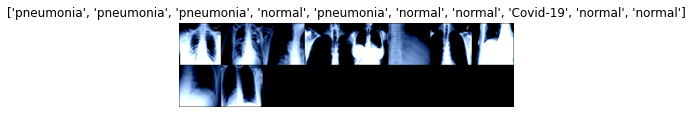

In [11]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

In [ ]:
num_features = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[:-7] # Remove last layer
print(features)

In [ ]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
features.extend([nn.Linear(num_features, 130)])

In [ ]:
features.extend([nn.Linear(130, 1000)])

In [ ]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

## Loss function = BCEWithLogitsLoss()

In [ ]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=1e-1,momentum=0.9)

In [ ]:
def to_one_hot(x, C=2, tensor_class=torch.FloatTensor):
    """ One-hot a batched tensor of shape (B, ...) into (B, C, ...) """
    x_one_hot = tensor_class(x.size(0), C, *x.shape[1:]).zero_()
    x_one_hot = x_one_hot.scatter_(1, x.unsqueeze(1), 1)
    return x_one_hot

# Demonstration:
num_classes = 3
labels = torch.LongTensor(130).random_(0, num_classes)
one_hot_labels = to_one_hot(labels, C=num_classes)
print(one_hot_labels.shape)

## Loss Function = FocalLoss()

In [ ]:
def FocalLoss(self.gamma)
    logit = logit.clamp(self.eps,1. - self.eps)
    FocalLoss=-1*p*torch.log(logit)*(1-logit)**self.gamma
return FocalLoss.sum()

In [ ]:
Epochs = 10
criterion = FocalLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=1e-1,momentum=0.9)

In [ ]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')

print('Finished Training')

In [ ]:
acc=[]
correct = 0
total = 0
with torch.no_grad():
    for k in range(Epochs):
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc.append(100*correct/total)

print('Accuracy of the network on Training images: %d %%' % (
    100 * correct / total))
epocharray=range(0,Epochs)
plt.plot(epocharray,acc)
plt.ylabel('Training Accuracy')
plt.xlabel('Epochs')

In [ ]:
acc=[]
correct = 0
total = 0
with torch.no_grad():
    for k in range(Epochs):
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc.append(100*correct/total)

print('Accuracy of the network on Validation images: %d %%' % (
    100 * correct / total))
epocharray=range(0,Epochs)
plt.plot(epocharray,acc)
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')

In [ ]:
nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

In [ ]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))
skplt.metrics.plot_confusion_matrix(classes, preds, figsize=(4,4), normalize=True)
plt.show()

In [ ]:
nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(valloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

In [ ]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))
skplt.metrics.plot_confusion_matrix(classes, preds, figsize=(4,4), normalize=True)
plt.show()

## Resnet

In [12]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
print('Output Layer of Resnet18 : ', resnet18.fc.out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Removing layers

In [13]:
#num_features = vgg16.classifier[0].in_features
#features = list(vgg16.classifier.children())[:-7] # Remove last layer
#print(features)

## Freezing Layers

In [14]:
# Freeze training for all layers
#for param in resnet18.layer1.parameters():
 #   param.requires_grad = True

In [15]:
#for param in resnet18.layer2.parameters():
 #   param.requires_grad = True

In [16]:
#for param in resnet18.layer3.parameters():
    #param.requires_grad = True

In [17]:
#for param in resnet18.layer4.parameters():
 #   param.requires_grad = True

## Adding Layers 

In [18]:
#fc1= nn.Linear(512,130, bias=True)
#resnet18.fc = nn.Sequential(fc1)
#fc2= nn.Linear(130,2, bias=True)
#resnet18.fc = nn.Sequential(fc1,fc2)

In [19]:
#print(resnet18.fc)

In [20]:
#print(resnet18.layer1)

## Loss and optimization BCEWithLogitsLoss()

In [21]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=1e-1,momentum=0.9)

## Loss and optimization FocalLoss()

In [ ]:
def FocalLoss(self.gamma)
    logit = logit.clamp(self.eps,1. - self.eps)
    FocalLoss=-1*p*torch.log(logit)*(1-logit)**self.gamma
return FocalLoss.sum()

In [ ]:
Epochs = 10
criterion = FocalLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=1e-1,momentum=0.9)

In [22]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))

        
    torch.save(resnet18.state_dict(), 'vgg16_ft.pth')

print('Finished Training')

    

Train Epoch: 0 [26/261 (96%)]	Loss: 1.358372: : 27it [01:55,  4.26s/it] 
Train Epoch: 1 [26/261 (96%)]	Loss: 1.128717: : 27it [02:18,  5.14s/it] 
Train Epoch: 2 [26/261 (96%)]	Loss: 1.039554: : 27it [02:57,  6.58s/it] 
Train Epoch: 3 [26/261 (96%)]	Loss: 0.279813: : 27it [02:37,  5.82s/it] 
Train Epoch: 4 [26/261 (96%)]	Loss: 0.597621: : 27it [02:37,  5.82s/it] 
Train Epoch: 5 [26/261 (96%)]	Loss: 1.703706: : 27it [02:36,  5.81s/it] 
Train Epoch: 6 [26/261 (96%)]	Loss: 1.265335: : 27it [02:35,  5.77s/it] 
Train Epoch: 7 [26/261 (96%)]	Loss: 2.432551: : 27it [01:59,  4.42s/it] 
Train Epoch: 8 [26/261 (96%)]	Loss: 1.669775: : 27it [01:58,  4.37s/it] 
Train Epoch: 9 [26/261 (96%)]	Loss: 0.969397: : 27it [01:55,  4.27s/it] 


Finished Training


Accuracy of the network on Training images: 73 %


Text(0.5, 0, 'Epochs')

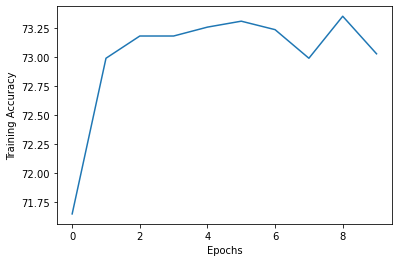

In [23]:
acc=[]
correct = 0
total = 0
with torch.no_grad():
    for k in range(Epochs):
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc.append(100*correct/total)

print('Accuracy of the network on Training images: %d %%' % (
    100 * correct / total))
epocharray=range(0,Epochs)
plt.plot(epocharray,acc)
plt.ylabel('Training Accuracy')
plt.xlabel('Epochs')

In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 25.,   6.,  29.],
        [  0., 100.,  12.],
        [ 14.,  13.,  62.]])


In [26]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.4167, 0.8929, 0.6966])


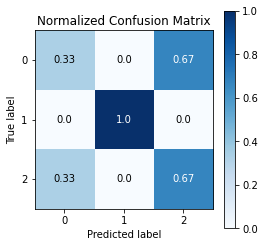

In [36]:

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(classes, preds, figsize=(4,4), normalize=True)
plt.show()


In [37]:
from sklearn.metrics import f1_score
f1_score(classes, preds, average='macro')
f1_score(classes, preds, average='micro')
f1_score(classes, preds, average='weighted')
f1_score(classes, preds, average=None)
#f1_score(classes, preds, zero_division=1)

array([0.4       , 1.        , 0.57142857])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


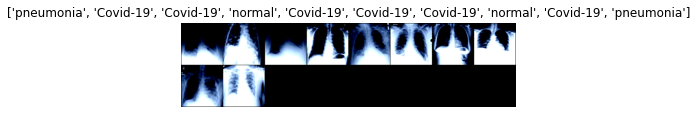

In [29]:
dataiter = iter(valloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [30]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  pneumonia pneumonia normal normal pneumonia Covid-19 normal normal pneumonia pneumonia
Ground Truth:  pneumonia Covid-19 Covid-19 normal Covid-19 Covid-19 Covid-19 normal Covid-19 pneumonia


Accuracy of the network on Validation images: 54 %


Text(0.5, 0, 'Epochs')

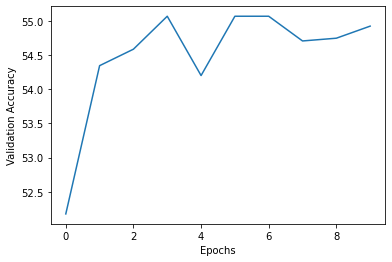

In [31]:
acc=[]
correct = 0
total = 0
with torch.no_grad():
    for k in range(Epochs):
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc.append(100*correct/total)

print('Accuracy of the network on Validation images: %d %%' % (
    100 * correct / total))
epocharray=range(0,Epochs)
plt.plot(epocharray,acc)
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
    

In [32]:
nb_classes = 3

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(valloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 5.,  4., 15.],
        [ 0., 20.,  2.],
        [ 6.,  4., 13.]])


In [33]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.2083, 0.9091, 0.5652])


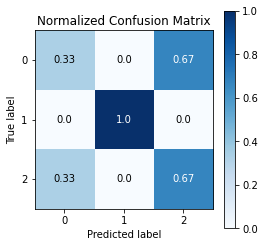

In [34]:

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(classes, preds, figsize=(4,4), normalize=True)
plt.show()


In [35]:
from sklearn.metrics import f1_score
f1_score(classes, preds, average='macro')
f1_score(classes, preds, average='micro')
f1_score(classes, preds, average='weighted')
f1_score(classes, preds, average=None)
#f1_score(classes, preds, zero_division=1)

array([0.4       , 1.        , 0.57142857])

## with multilabel classifcation

In [ ]:
multilabel_confusion_matrix(classes, preds)
print(classification_report(classes,preds))

## Test Dataset

In [4]:
from PIL import Image
import os, os.path

imgs = []
path = "D:/HP 1000/Local Disk D/e drive data/PhD ITU/Deep Learning/Assignment5/Part 2/Test/Test"
valid_images = [".jpg",".gif",".png",".tga"]
for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    imgs.append(Image.open(os.path.join(path,f)))

In [5]:
print(imgs)

[<PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x2CCC0BAFF88>, <PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x2CCC0BAFE88>, <PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x2CCC0C782C8>, <PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x2CCC0C7CC08>, <PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x2CCC0C7CBC8>, <PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x2CCC0C7CE48>, <PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x2CCC0C7CE88>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=424x443 at 0x2CCC0C820C8>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2412x2244 at 0x2CCC0C82448>, <PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x2CCC0BAFF08>, <PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x2CCC0C7CFC8>, <PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x2CCC0C89588>, <PIL.PngImagePlugin.PngImageFile 

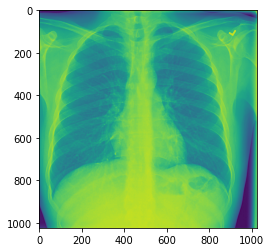

In [8]:
plt.imshow(imgs[0])

In [ ]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the _getitem_ method. this is the method that dataloader calls
    def _getitem_(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self)._getitem_(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# EXAMPLE USAGE:
# instantiate the dataset and dataloader
data_dir = "./gdrive/My Drive/Copy of Assignment 5 Dataset.zip" -d "./gdrive/My Drive/test"
dataset = ImageFolderWithPaths(data_dir) # our custom dataset
dataloader = DataLoader(dataset)
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


test_data = ImageFolderWithPaths(data_dir_vl + '/test', transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

class_names = test_data.classes
score=[]
name=[]
print(class_names)
for inputs, labels, paths in testloader:
    # use the above variables freely
    model.eval()
    nm=os.path.basename(os.path.normpath(paths[0]))
    image=inputs.to(device)
    outputs = (model(image))
    print('\r',outputs,end='')
    gt=outputs.detach().to('cpu').numpy()
    score.append((gt[0]>0.5)*1)
    name.append(nm)
a=np.matrix(name)
b=np.asarray(score)#.reshape(0,-1)
res = np.concatenate((a.T, b[:,0:1]), axis=1)
res = np.concatenate((res,b[:,2:3]),axis=1)
res = np.concatenate((res,b[:,1:2]),axis=1)
print(res)
np.savetxt("D:/HP 1000/Local Disk D/e drive data/PhD ITU/Deep Learning/Assignment5/Part 2/Test/Test/PhDEE19003_results.csv", res,delimiter=',',  fmt='%s')